# 03_05_morescipy.ipynb - Interpolation and optimization with SciPy

In [1]:
import numpy as np
import matplotlib.pyplot as pp

import numba

import astropy.constants
import astropy.time
import astropy.coordinates

import scipy.integrate
import scipy.interpolate
import scipy.optimize

#### Solar System integrator from 03_04

In [2]:
bodies = ['sun','mercury','venus','earth','mars','jupiter','saturn','uranus','neptune']

massdict = {'sun': 1.0,
            'mercury': 1.6601209949637026e-07,
            'venus': 2.4478382857373332e-06,
            'earth': 3.0034896946063695e-06,
            'mars': 3.227156037857755e-07,
            'jupiter': 0.0009547918983127075,
            'saturn': 0.00028588567008942334,
            'uranus': 4.3662495719438076e-05,
            'neptune': 5.151383713179197e-05}

masses = np.array([massdict[body] for body in bodies])

In [3]:
G = astropy.constants.G.to('AU^3 / (Msun d^2)').value

In [4]:
@numba.jit
def ydot(t, y):
    # how many bodies? make sure the answer is an integer
    n = int(y.shape[0] / 6)

    # make an empty container for the derivatives
    yd = np.zeros_like(y)
    
    # for each body
    for i in range(n):
        # set x_i' = v_i (array slice assignment)
        yd[i*6:i*6+3] = y[i*6+3:i*6+6]
        
        # loop over all other bodies
        for j in range(n):
            if i == j:
                continue

            # add contribution of planet j to v_i'
            rij = y[j*6:j*6+3] - y[i*6:i*6+3]
            yd[i*6+3:i*6+6] += G * masses[j] * rij / np.dot(rij,rij)**1.5
    
    return yd

In [5]:
def get_posvel(body, t):
    posvel = astropy.coordinates.get_body_barycentric_posvel(body, t)
    
    return np.hstack([posvel[0].xyz.value.T, posvel[1].xyz.value.T])

In [6]:
t0, t1 = astropy.time.Time('2021-07-04'), astropy.time.Time('2031-07-04')

/Users/mvallisneri/opt/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [7]:
y0 = np.array([get_posvel(body, t0) for body in bodies]).flatten()

In [8]:
orbits = scipy.integrate.solve_ivp(ydot, [t0.mjd, t1.mjd], y0, rtol=1e-9, atol=1e-9)

#### Interpolating distances

In [9]:
orbits

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14096
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([59399.        , 59399.01853548, 59399.20389027, ...,
       63049.07117496, 63050.73704232, 63051.        ])
 t_events: None
        y: array([[-0.0077794 , -0.0077795 , -0.0077805 , ..., -0.00193163,
        -0.00194057, -0.00194198],
       [ 0.00434017,  0.00434005,  0.00433879, ...,  0.00122943,
         0.00122882,  0.00122872],
       [ 0.00203704,  0.00203699,  0.00203648, ...,  0.00062289,
         0.00062282,  0.0006228 ],
       ...,
       [ 0.00045921,  0.0004592 ,  0.00045914, ..., -0.00074487,
        -0.00074541, -0.00074549],
       [ 0.00288331,  0.00288331,  0.00288332, ...,  0.00283177,
         0.00283165,  0.00283163],
       [ 0.00116864,  0.00116864,  0.00116864, ...,  0.00117752,
         0.00117748,  0.00117748]])
 y_events: None

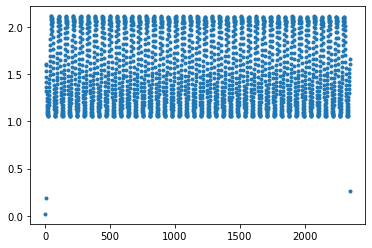

In [10]:
pp.plot(np.diff(orbits.t), '.')

In [11]:
orbint = scipy.interpolate.interp1d(orbits.t, orbits.y, kind='quadratic')

In [12]:
orbint(t0.mjd + 365.25)

array([-9.02301594e-03,  1.51342613e-03,  8.70028791e-04, -1.30776000e-06,
       -8.37142910e-06, -3.52179414e-06,  2.48693305e-01,  1.80036522e-01,
        6.95248268e-02, -2.22847067e-02,  2.02543452e-02,  1.31304740e-02,
        6.14885685e-01,  3.49947197e-01,  1.18178395e-01, -1.03061999e-02,
        1.55844515e-02,  7.66461144e-03,  1.98883075e-01, -9.11607729e-01,
       -3.94961220e-01,  1.65633737e-02,  3.15521819e-03,  1.36723640e-03,
        1.32123125e+00, -3.24903013e-01, -1.84744818e-01,  4.31500948e-03,
        1.33731223e-02,  6.01781525e-03,  4.93704396e+00, -2.99871982e-01,
       -2.48650111e-01,  4.78986422e-04,  7.24577280e-03,  3.09418855e-03,
        7.58596466e+00, -5.71598703e+00, -2.68788797e+00,  3.24619182e-03,
        3.99690213e-03,  1.51078150e-03,  1.38783540e+01,  1.28642102e+01,
        5.43775786e+00, -2.81564562e-03,  2.35294000e-03,  1.07053783e-03,
        2.96920257e+01, -2.97993601e+00, -1.95881463e+00,  3.39406794e-04,
        2.89749300e-03,  

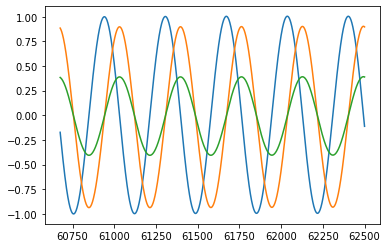

In [13]:
ts = astropy.time.Time('2025-01-01').mjd + np.arange(0, 5*365)
oneyear = orbint(ts)[3*6:4*6,:]

for i in range(3):
    pp.plot(ts, orbint(ts)[3*6+i,:], '-')

#### Finding minima

In [14]:
def get_dist(t, body1, body2, orbint):
    # get position of all bodies at time t
    y = orbint(t)
    
    # compute indices of each body
    i, j = bodies.index(body1), bodies.index(body2)
    
    # compute Euclidian distance
    return np.sqrt(np.sum((y[i*6:i*6+3] - y[j*6:j*6+3])**2, axis=0))

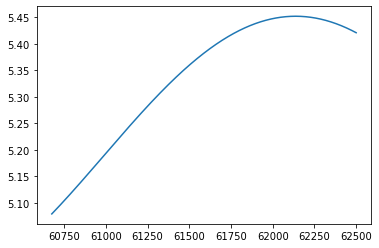

In [15]:
pp.plot(ts, get_dist(ts, 'jupiter', 'sun', orbint))

In [17]:
minimum = scipy.optimize.minimize(lambda t: -get_dist(t, 'jupiter', 'sun', orbint),
                                  x0=ts[900], bounds=[(ts[0],ts[-1])])

In [18]:
minimum

      fun: array([-5.4520989])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.13223253e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 28
      nit: 4
     njev: 14
   status: 0
  success: True
        x: array([62132.61072605])

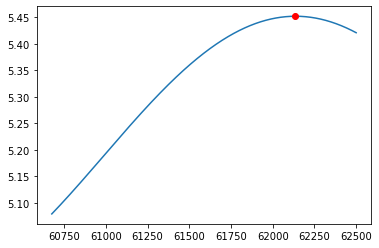

In [19]:
pp.plot(ts, get_dist(ts, 'jupiter', 'sun', orbint))
pp.plot(minimum.x, -minimum.fun, 'ro')

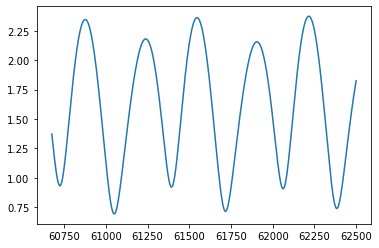

In [20]:
pp.plot(ts, get_dist(ts, 'mars', 'venus', orbint))

In [22]:
minimum = scipy.optimize.minimize(get_dist,
                                  x0=ts[900], args=('mars','venus',orbint),
                                  bounds=[(ts[0],ts[-1])])

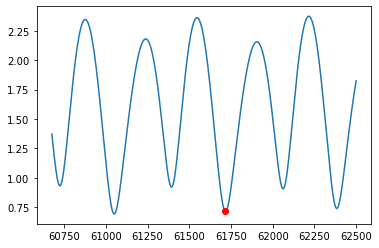

In [23]:
pp.plot(ts, get_dist(ts, 'mars', 'venus', orbint))
pp.plot(minimum.x, minimum.fun, 'ro')

In [24]:
for x0 in [61000,61750,62500]:
    minimum = scipy.optimize.minimize(get_dist, x0=x0, args=('mars','venus',orbint), bounds=[(ts[0],ts[-1])])
    print(minimum.x, minimum.fun)

[61050.12345755] [0.69236819]
[61716.93048361] [0.7143613]
[62383.99247217] [0.73882149]
